In [16]:
#download or load data set
from torch.utils.data import Dataset
import torch
from torchvision import datasets
from matplotlib import pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import torch.utils.data as data
import torchvision
import torch.optim as optim
import torch.nn as nn

def download_dataset(dataset_path,dataset_name):
    if dataset_name == "CIFAR10":
        train_dataset = datasets.CIFAR10(root=dataset_path, train=True,download=True)
        data_mean = (train_dataset.data / 255.0).mean(axis=(0,1,2))
        data_std = (train_dataset.data / 255.0).std(axis=(0,1,2))
        return data_mean,data_std
    else:
        raise NotImplementedError("downloading for this dataset is not implemented")

def get_cifar10_classes():
    labels = ["airplane","automobile","bird","cat",
              "deer","dog","frog","horse","ship","truck"]
    return labels

In [2]:
download_dataset("./data","CIFAR10")

Files already downloaded and verified


(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

In [3]:
train_dataset = datasets.CIFAR10(root="./data", train=True,download=True)

Files already downloaded and verified


In [4]:
def show_images(imgs,nrow,ncol,titles = None):
    '''
    --args 
    imgs: a list of images(PIL or torch.tensor or numpy.ndarray)
    nrow: the number of rows
    ncol: the number of columns
    titles: the tile of each subimages
    note that the size an image represented by PIL or ndarray is (W*H*C),
              but for tensor it is (C*W*H)
    --returns
    fig and axes
    '''
    fig,axes = plt.subplots(nrow,ncol)
    for i in range(len(imgs)):
        row  = i // ncol
        col = i % ncol
        if titles:
            axes[row,col].set_title(titles[i])
        if isinstance(imgs[i],Image.Image):
            img = np.array(imgs[i])
        elif torch.is_tensor(imgs[i]):
            img = imgs[i].cpu().detach()
            img = img.permute((1,2,0)).numpy()
        elif isinstance(imgs[i], np.ndarray):
            img = imgs[i]
        else:
            raise TypeError("each image must be an PIL or torch.tensor or numpy.ndarray")
        axes[row,col].imshow(img)
        axes[row,col].set_axis_off()
    return fig,axes
        
    

Files already downloaded and verified


(<Figure size 640x480 with 12 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

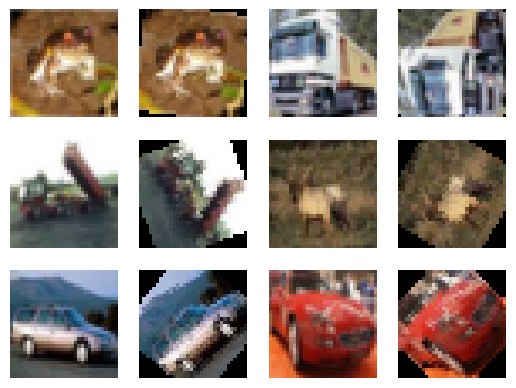

In [5]:
t = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root="./data", train=True,download=True,transform=t)
imgs = [train_dataset[i][0] for i in range(12)]
r = transforms.RandomRotation(90)
imgs = []
for i in range(6):
   imgs.append(train_dataset[i][0]) 
   imgs.append(r(train_dataset[i][0]))
show_images(imgs,3,4)

In [6]:
class AugumentationTransformations(object):
    '''
    for image augumentation
    '''
    def __init__(self, my_transforms, n_views=2):
        '''
        --args:
        my_transforms: torchvison.transforms object that transforms the image
        n_views: the number of transfomed images augmented for each orginal image
        '''
        self._transforms = my_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self._transforms(x) for i in range(self.n_views)]


In [7]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor()
                                         ])

In [8]:
train_dataset = datasets.CIFAR10(root="./data", train=True,download=True,transform=AugumentationTransformations(contrast_transforms, n_views=3))
loader = data.DataLoader(train_dataset, batch_size=4, shuffle=False)

Files already downloaded and verified


tensor([6, 9, 9, 4, 6, 9, 9, 4, 6, 9, 9, 4])
tensor([6, 9, 9, 4])


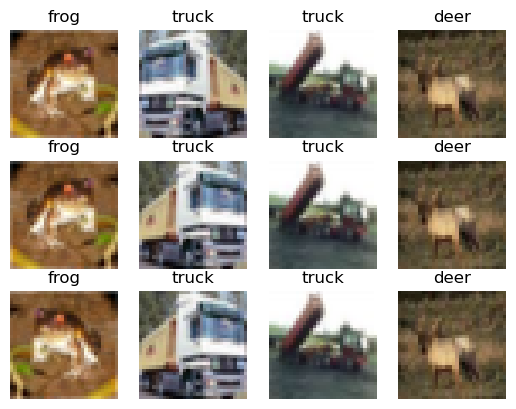

In [9]:
x,y = next(iter(loader))
classes = get_cifar10_classes()
imgs,labels = [],[]
for i in range(3):
    for j in range(4):
        imgs.append(x[i][j,:,:])
        labels.append(classes[y[j]])
show_images(imgs,3,4,labels)
print(y.repeat(3))
print(y)

(<Figure size 640x480 with 12 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

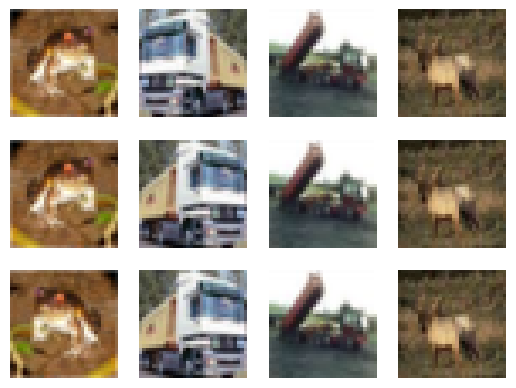

In [10]:
xx = torch.cat(x,dim=0)
imgs = []
for i in range(12):
    imgs.append(xx[i,:,:])
show_images(imgs,3,4)

Files already downloaded and verified
torch.Size([64, 3, 32, 32])


(<Figure size 640x480 with 6 Axes>,
 array([[<Axes: title={'center': 'frog'}>,
         <Axes: title={'center': 'bird'}>,
         <Axes: title={'center': 'cat'}>],
        [<Axes: title={'center': 'dog'}>,
         <Axes: title={'center': 'automobile'}>,
         <Axes: title={'center': 'automobile'}>]], dtype=object))

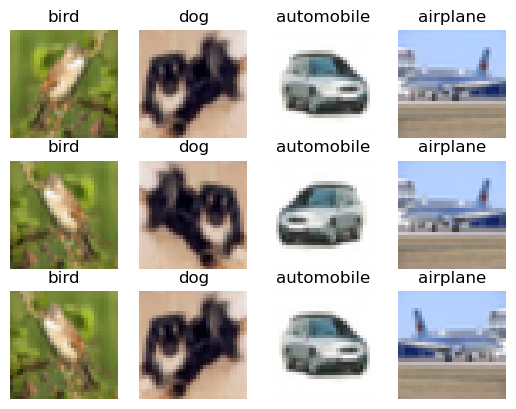

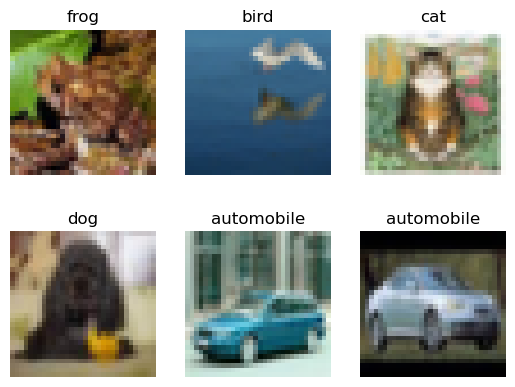

In [45]:
class WrappedDataset(Dataset):
    def __init__(self, dataset, transform=None, n_views = 1):
        self.dataset = dataset
        self.transform = transform
        self.n_views = n_views
        
    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = [self.transform(x) for i in range(self.n_views)]
            y = [y for i in range(self.n_views)]
        return x, y
        
    def __len__(self):
        return len(self.dataset)

train_dataset = datasets.CIFAR10(root="./data", train=True,download=True,transform=None)
_train_set, _val_set = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
train_set = WrappedDataset(_train_set,contrast_transforms, n_views=3)
val_set = WrappedDataset(_val_set,transforms.ToTensor())

train_loader = data.DataLoader(train_set, batch_size=64, shuffle=False)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False)

x,y = next(iter(train_loader))
imgs,labels = [],[]
for i in range(3):
    for j in range(4):
        imgs.append(x[i][j,:,:])
        labels.append(classes[y[i][j]])
show_images(imgs,3,4,labels)

x,y = next(iter(val_loader))
print(x[0].shape)
imgs = [x[0][i,:,:] for i in range(6)]
labels = [classes[y[0][i]] for i in range(6)]
show_images(imgs,2,3,labels)

In [46]:
# initialize resnet
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
net = torchvision.models.resnet18(num_classes=10).to(device) 
optimizer = optim.SGD(net.parameters(),lr=0.1,momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
a = torch.rand(10)
print(a.size()[0])

10


In [47]:
def test_model(net, data_loader):
    net.eval()
    true_preds, count = 0., 0
    for imgs,labels in data_loader:
        imgs, labels = imgs[0].to(device), labels[0].to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

In [48]:
# train a model
n_views = 3
batch_size = 4
n_epoch = 10
for epoch in range(n_epoch):
    n_true,n_sample = 0,0
    for imgs,labels in train_loader:
        net.train()
        imgs = torch.cat(imgs,dim=0)
        labels = torch.cat(labels,dim=0)
        imgs,labels = imgs.to(device),labels.to(device)
        optimizer.zero_grad()
        # for supervised learning
        preds = net(imgs)
        loss = loss_fn(preds,labels)
        loss.backward()
        optimizer.step()
        n_true += (torch.argmax(preds,dim=1) == labels).sum()
        n_sample += labels.size()[0]
    train_acc = n_true/n_sample
    print("epoch={},training accuracy is {:.3f}\n".format(epoch,train_acc))
    test_acc = test_model(net,val_loader)
        
        
        

epoch=0,training accuracy is 0.314

epoch=1,training accuracy is 0.483

epoch=2,training accuracy is 0.577

epoch=3,training accuracy is 0.644

epoch=4,training accuracy is 0.689

epoch=5,training accuracy is 0.721

epoch=6,training accuracy is 0.751

epoch=7,training accuracy is 0.777

epoch=8,training accuracy is 0.799

epoch=9,training accuracy is 0.820

